# Church & Temple Classification - Training Notebook

Here we will attempt a variety of techniques for classifying churches and temples from 11 different countries.  We assume that rotation has already been corrected by a separate process.

We have a few tricks up our sleeve to handle this kind of data.

1. __Augmentations__:  See `load_and_preprocess_data.ipynb`.  Every time an image is loaded from disk, it goes through a randomized set of augmentations, including random cropping, shearing, zooming, channel shift, horizontal flipping.
2. __Adjusted Sampling Rates__: Customize sampling rates from each country proportional to sqrt(N).  For instance, Russia has 11x as many images as Armenia, but will be sampled approximately 3.4x the rate of Armenia.
3. __Imbalanced Sample/Class Weights__: Increase the training weights of classes with few samples (Armenia, Australia)
4. __Transfer Learning from Pretrained Network__:  We will use Xception pre-trained network, which has excellent imagenet performance and relatively small (20M parameters).  When you remove the top, it emits a 10x10x2048 output for each image.  We might start with a global max/avg pooling, since we don't need the spatial information
5. __Add Intermediate Layer Outputs__:  In addition to using the 10x10x2048 output of Xception, we will grab the outputs from an intermediate layer in the network.  The reason for this is that high-frequency image components are likely to be valuable, since some countries' temples are very similiar, varying only by small deviations in shapes.  Also, it has additional value for picking up the "style" of the surroundings (much like is used in style transfer)
7. __Generators for Sampling from Disk__: We don't pull all the images into memory because it's a ton of data.  Instead we created a tf.data.Dataset from a generator that reads the images from disk on-the-fly.  *This is slow*, but likely necessary depending on the training environment.
8. __K-fold Cross-Validation__: Because there are so few images for some classes, it's just not possible to get reasonable performance metrics (such as Armenia with 11 images).  If we do k-fold cross-validation, we can at least get some idea on all 11 images.
5. __Fine-Tuning__:  After finding a good classifier architecture, we want to train a model regularly, then unfreeze some of the layers of the Xception network so that it can learn better representations before reaching our custom layers.
5. __Label Smoothing__:  Because you pretty much always do this with neural net classifiers...
6. __(SKIPPED) Triple Loss Training__: I **really** wanted to try this method, but just didn't have time amidst all the other training.  Plus I got satisfactory results without it.

------

In [1]:
import cv2
import os
import platform
import sys
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import sklearn
import numpy as np
import seaborn as sns
 
import tensorflow as tf
from tensorflow import keras
import tensorflow.keras.layers as L

print("OS Name: %s" % platform.system())
print(f'Using Python={sys.version_info.major}.{sys.version_info.minor}.{sys.version_info.micro}')
print(f'Using Numpy={np.__version__}')
print(f'Using Matplotlib={matplotlib.__version__}')
print(f'Using Tensorflow={tf.__version__}')
print("GPU Available: ", tf.config.list_physical_devices('GPU'))

/home/alan/projects/venv-jupyter/lib/python3.7/site-packages/pandas/compat/__init__.py:84: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


OS Name: Linux
Using Python=3.7.2
Using Numpy=1.17.1
Using Matplotlib=3.1.2
Using Tensorflow=2.1.0
GPU Available:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True) 

In [3]:
%load_ext autoreload
%autoreload 2

------

# Xception Network Architecture - Text Version
<img src="https://i.imgur.com/tA2qDIQ.jpg" width="800" height="800"/>

# Xception Network Architecture - Visualization
<img src="https://miro.medium.com/max/1451/1*NNsznNjzULwqvSER8k5eDg.png" width="900" height="600"/>



## First use our TrainDataInfo class to process and prepare all of our training data.
This indexes all training image paths, and calculates the adjusted sampling probabilities and training weights.  It also precomputes the different train-test splits that will be used for cross-validation

In [4]:
from load_and_preprocess_data import TrainDataInfo
from image_utilities import ImageUtilities
from training_utils import TrainingUtils

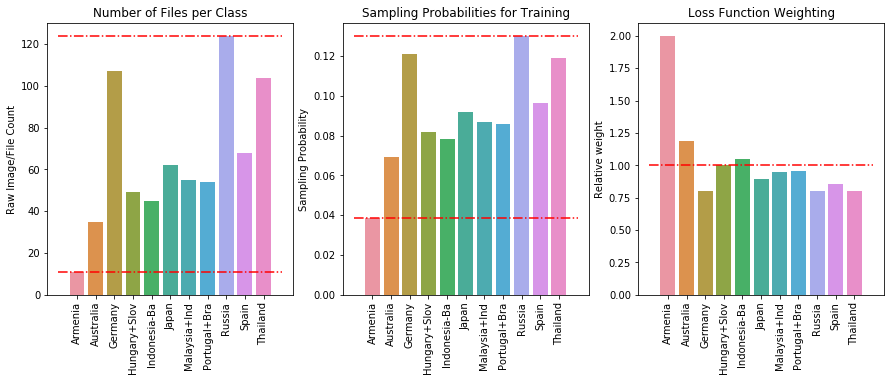

In [5]:
BATCH_SIZE=16
TRAIN_FOLDER='train_fixed_rotation'

# We set global parameters for our feature extractor -- currently Xception
INPUT_IMG_SIZE_2 = (299, 299)
INPUT_IMG_SIZE_3 = INPUT_IMG_SIZE_2 + (3,)

# This is used to abstract out the base, pre-trained network
def FEX_BASE_CREATE(trainable=False):
    #print(f'Creating feature extractor base model, trainable={trainable}')
    model = Xception(weights='imagenet', include_top=False)
    model.trainable = trainable
    return model

all_train_info = TrainDataInfo(TRAIN_FOLDER, kfold_splits=5)
train_utils = TrainingUtils(all_train_info, INPUT_IMG_SIZE_3, BATCH_SIZE)
NUM_COUNTRIES = len(all_train_info.country_names)
all_train_info.display_rel_counts()

In [6]:
# Need to test the generator creation functions
gen = train_utils.train_data_generator_disk(0, INPUT_IMG_SIZE_2)
train_ds = train_utils.generator_to_dataset(gen, INPUT_IMG_SIZE_3, NUM_COUNTRIES, BATCH_SIZE)
test_ds = train_utils.create_test_dataset(0, INPUT_IMG_SIZE_3, batch_size=3)
for batch in train_ds.take(2):
    print(f'Train batch: {batch[0].shape}, {batch[1].shape}')
for batch in test_ds.take(2):
    print(f'Test batch:  {batch[0].shape}, {batch[1].shape}')

Train batch: (16, 299, 299, 3), (16, 11)
Train batch: (16, 299, 299, 3), (16, 11)
Test batch:  (1, 299, 299, 3), (1, 11)
Test batch:  (1, 299, 299, 3), (1, 11)


----
# Generate Baseline Performance
We will use the updated sampling rates, but create a network that is just a logistic regression on top of Xception outputs.  This is what we did for rotation detection (but in this case we'll build it into a Keras model).


In [6]:
from tensorflow.keras.applications import Xception
from tensorflow.keras.applications.inception_v3 import preprocess_input as xcept_preproc

# Use this image and method to sanity check that created models take correct input, confirm output shape
# The Xception model has (None,None) for all layer sizes, making it difficult to 
zeros_img = np.zeros(shape=(1,) + INPUT_IMG_SIZE_3, dtype='float32')
print_output_shape = lambda model: print(f'Model output shape is {model(zeros_img).numpy().squeeze().shape}')

In [9]:
def generate_xception_logreg_model():
    x = inputs = L.Input(shape=INPUT_IMG_SIZE_3)
    x = FEX_BASE_CREATE()(x)
    
    # The GlobalAvgPooling is removed when you load Xception with_top=False.  Add it back.
    x = L.GlobalAvgPool2D()(x)
    
    # Add a small hidden layer between the Xception outputs and the logistic-regression layer
    x = L.Dense(64)(x)
    x = L.LeakyReLU(alpha=0.15)(x)
    x = L.Dropout(0.15)(x)

    # This is the logistic regression head
    x = predictions = L.Dense(NUM_COUNTRIES, activation='sigmoid')(x)
    
    return keras.models.Model(inputs=inputs, outputs=predictions)

simplest_model = generate_xception_logreg_model()
print_output_shape(simplest_model)
simplest_model.summary()

Creating feature extractor base model, trainable=False
Model output shape is (11,)
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 299, 299, 3)]     0         
_________________________________________________________________
xception (Model)             multiple                  20861480  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 64)                131136    
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 64)                0         
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
____________________________________________

In [10]:
# In jupyter lab this creates the image, but doesn't display inline.  Meh...
try:
    tf.keras.utils.plot_model(simplest_model, show_shapes=True, dpi=64)
except Exception as e:
    print('Failed to generate visual model')
    raise

In [10]:
model, y_true, y_pred, hist = train_utils.train_eval_kfold_crossval(generate_xception_logreg_model, epochs=40, finetune_epochs=0)

Filling image cache
Creating new model for fold 0
Creating feature extractor base model, trainable=False
Epoch 1/40
36/36 [==============================] - 45s 1s/step - loss: 3.1654 - accuracy: 0.2500 - val_loss: 2.2026 - val_accuracy: 0.1986
Epoch 2/40
36/36 [==============================] - 43s 1s/step - loss: 3.0946 - accuracy: 0.4225 - val_loss: 2.1185 - val_accuracy: 0.2603
Epoch 3/40
36/36 [==============================] - 43s 1s/step - loss: 2.8925 - accuracy: 0.4613 - val_loss: 2.0447 - val_accuracy: 0.2329
Epoch 4/40
36/36 [==============================] - 43s 1s/step - loss: 2.8703 - accuracy: 0.5475 - val_loss: 1.9438 - val_accuracy: 0.3288
Epoch 5/40
36/36 [==============================] - 42s 1s/step - loss: 2.7826 - accuracy: 0.5687 - val_loss: 1.8781 - val_accuracy: 0.3973
Epoch 6/40
36/36 [==============================] - 42s 1s/step - loss: 2.7383 - accuracy: 0.6391 - val_loss: 1.8268 - val_accuracy: 0.4178
Epoch 7/40
36/36 [==============================] - 42s

/home/alan/projects/venv-jupyter/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Creating new model for fold 1
Creating feature extractor base model, trainable=False
Epoch 1/40
36/36 [==============================] - 45s 1s/step - loss: 3.2168 - accuracy: 0.2214 - val_loss: 2.2767 - val_accuracy: 0.1310
Epoch 2/40
36/36 [==============================] - 42s 1s/step - loss: 3.0953 - accuracy: 0.4025 - val_loss: 2.1956 - val_accuracy: 0.1862
Epoch 3/40
36/36 [==============================] - 43s 1s/step - loss: 2.9692 - accuracy: 0.4710 - val_loss: 2.0663 - val_accuracy: 0.1931
Epoch 4/40
36/36 [==============================] - 43s 1s/step - loss: 2.8233 - accuracy: 0.5782 - val_loss: 1.9746 - val_accuracy: 0.2828
Epoch 5/40
36/36 [==============================] - 43s 1s/step - loss: 2.7638 - accuracy: 0.5993 - val_loss: 1.8783 - val_accuracy: 0.3034
Epoch 6/40
36/36 [==============================] - 42s 1s/step - loss: 2.7979 - accuracy: 0.6151 - val_loss: 1.8949 - val_accuracy: 0.3172
Epoch 7/40
36/36 [==============================] - 42s 1s/step - loss: 2.6

## Display Baseline Results
These are the results using just standard **Xception** 2048 outputs with an intermediate 64-node layer before the logistic regression.

                          precision    recall  f1-score   support

                 Armenia       1.00      0.18      0.31        11
               Australia       0.29      0.71      0.42        35
                 Germany       0.55      0.21      0.30       107
Hungary+Slovakia+Croatia       0.19      0.24      0.21        49
          Indonesia-Bali       0.72      0.29      0.41        45
                   Japan       0.90      0.74      0.81        62
      Malaysia+Indonesia       0.86      0.67      0.76        55
         Portugal+Brazil       0.23      0.91      0.37        54
                  Russia       0.79      0.47      0.59       124
                   Spain       0.41      0.19      0.26        68
                Thailand       0.81      0.75      0.78       104

                accuracy                           0.50       714
               macro avg       0.61      0.49      0.47       714
            weighted avg       0.63      0.50      0.51       714



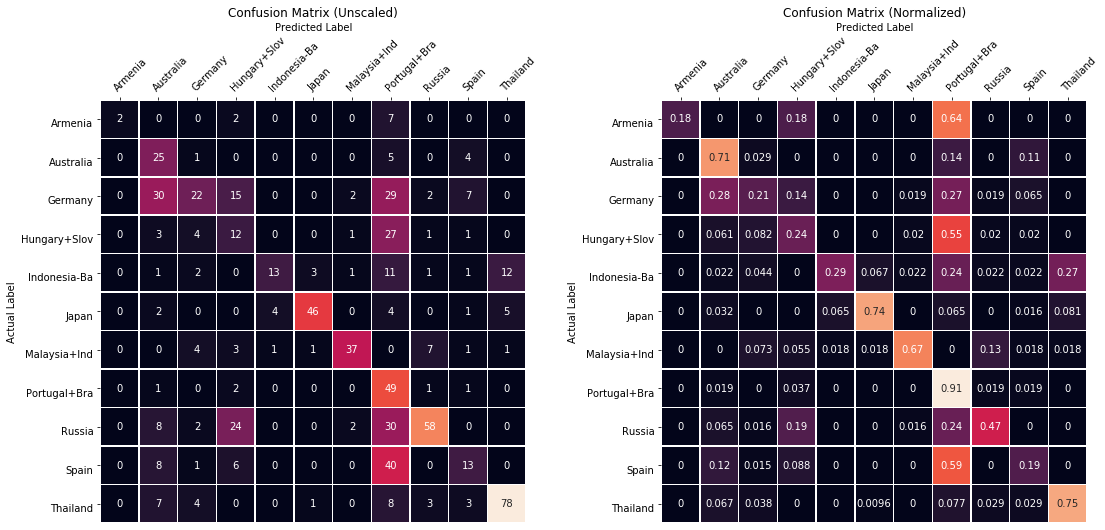

In [11]:
train_utils.display_heatmaps(y_true, y_pred)
train_utils.print_classification_report(y_true, y_pred)

------
## Create a More Complex Model
We're going to add intermediate layers to the output.  We want early-middle layers where finer-grained convolution kernels are applied.

In [19]:
# The name of the intermediate layer we want is not consistent.  But the overall architecture
# is, so we will get it by index.  We want an early-middle layer to get high-freq info.
print('List of layers by index:')
fex_model = FEX_BASE_CREATE()
for i,l in enumerate(fex_model.layers):
    print('  ', i, l.name)

List of layers by index:
Creating feature extractor base model, trainable=False
   0 input_9
   1 block1_conv1
   2 block1_conv1_bn
   3 block1_conv1_act
   4 block1_conv2
   5 block1_conv2_bn
   6 block1_conv2_act
   7 block2_sepconv1
   8 block2_sepconv1_bn
   9 block2_sepconv2_act
   10 block2_sepconv2
   11 block2_sepconv2_bn
   12 conv2d_32
   13 block2_pool
   14 batch_normalization_32
   15 add_96
   16 block3_sepconv1_act
   17 block3_sepconv1
   18 block3_sepconv1_bn
   19 block3_sepconv2_act
   20 block3_sepconv2
   21 block3_sepconv2_bn
   22 conv2d_33
   23 block3_pool
   24 batch_normalization_33
   25 add_97
   26 block4_sepconv1_act
   27 block4_sepconv1
   28 block4_sepconv1_bn
   29 block4_sepconv2_act
   30 block4_sepconv2
   31 block4_sepconv2_bn
   32 conv2d_34
   33 block4_pool
   34 batch_normalization_34
   35 add_98
   36 block5_sepconv1_act
   37 block5_sepconv1
   38 block5_sepconv1_bn
   39 block5_sepconv2_act
   40 block5_sepconv2
   41 block5_sepconv2_bn
  

### Create Final Model Code
This is the final model that will be used in the deliverable, so write it to file instead of just creating it locally.  Because this is the core executable file, we also need to write the utilities to run the model from the trained weights file.


In [23]:
%%writefile final_model.py
import argparse
import cv2
import os
import numpy as np
import subprocess
from tensorflow import keras
import tensorflow.keras.layers as L
from tensorflow.keras.applications import Xception
from tensorflow.keras.applications.inception_v3 import preprocess_input as xcept_preproc

from image_utilities import ImageUtilities
from rotation_correction import RotationCorrection

# Some global parameters
INPUT_IMG_SIZE_2D = (299, 299)
INPUT_IMG_SIZE_3D = (299, 299, 3)
INTERMEDIATE_LAYERS = [45, 65, 95] # Output of Xception blocks 3, 5 and 8
COUNTRY_NAMES = ['Armenia', 'Australia', 'Germany', 'Hungary+Slovakia+Croatia',
                 'Indonesia-Bali', 'Japan', 'Malaysia+Indonesia', 'Portugal+Brazil',
                 'Russia', 'Spain', 'Thailand']
NUM_COUNTRIES = len(COUNTRY_NAMES)
FINAL_MODEL_WEIGHTS_FILENAME = 'church_temple_classify_weights.hdf5'
FEX_BASE_NAME = 'Xception'

# This can be imported directly to create the model without the trained weights
def generate_multi_out_xception_model(weights_file=None):
    fex_base = Xception(weights='imagenet', include_top=False)
    inp_layer = fex_base.layers[0].input
    inter_layers = [fex_base.layers[l].output for l in INTERMEDIATE_LAYERS]
    out_layer = fex_base.layers[-1].output
    
    # GlobalAvgPooling of all 3 intermediate layers and the normal Xception output layer
    x = multiple_inters = [L.GlobalAveragePooling2D()(lout) for lout in (inter_layers + [out_layer])]
    
    # Concatenate those four layers together into a 4,232-feature vector
    x = combined = L.Concatenate(axis=-1)(multiple_inters)
    
    # Intermediate 64-dense layer between the above and the logistic regression head
    x = L.Dense(64)(x)
    x = L.LeakyReLU(alpha=0.15)(x)
    x = L.Dropout(0.15)(x)
    
    # Here's the logistic regression part...
    x = predictions = L.Dense(NUM_COUNTRIES, activation='sigmoid')(x)
    
    model = keras.models.Model(inputs=inp_layer, outputs=predictions)
    if weights_file:
        model.load_weights(weights_file)
        
    return model


class ChurchTempleClassifier:
    
    def __init__(self, main_hdf5_file=None, rotate_clf_file=None):
        self.main_model_file = FINAL_MODEL_WEIGHTS_FILENAME
        self.rotate_model_file = rotate_clf_file
        
        # This handles downloading the file if it doesn't exist yet (or unspecified)
        self.rotate_model = RotationCorrection(self.rotate_model_file)
        
        # Need to implement downloading file if it doesn't exist, for main model
        if self.main_model_file is None or not os.path.exists(self.main_model_file):
            # Download with wget (to avoid the caller needing boto3 library)
            try:
                s3obj = f'https://acr-toptal-codingproj.s3.amazonaws.com/{FINAL_MODEL_WEIGHTS_FILENAME}'
                print(f'Attempting to download: {s3obj}')
                subprocess.check_call(['wget', s3obj])
                print(f'Successful!')
            except Exception as e:
                raise 
                
            self.main_model_file = s3obj.split('/')[-1]
        else:
            print(f'Using already-downloaded model file: {self.main_model_file}')
                                    
        print(f'Loading main classifier weights:  {self.main_model_file}')
        self.main_model = generate_multi_out_xception_model(self.main_model_file)
        

    def process_one_file(self, img_path):
        """
        Given an image path, run the model to predict the country
        """
        if not os.path.splitext(img_path)[-1].lower() in ['.jpg', '.jpeg', '.png', '.bmp']:
            print(f'Skipping non-image file: {img_path}')
            return None
        
        img = ImageUtilities.load_image(img_path, xcept_preproc)
        img = cv2.resize(img, INPUT_IMG_SIZE_2D)
        img, _ = self.rotate_model.fix_one_image(img)
        img = np.expand_dims(img, axis=0)
        
        model_out = self.main_model(img)
        out_idx = np.argmax(model_out.numpy().reshape([-1]))
        return COUNTRY_NAMES[out_idx]
        
        
    def process_directory(self, dir_path):
        """
        Given a directory, run process_one_file on all images in the dir.  Creates .csv as output.
        """
        print(f'Processing all images in directory: {dir_path}')
        out_filename = f'classify_results_{dir_path.replace("/", "_")}.csv'
        with open(out_filename, 'w') as fwrite:
            for img_file in os.listdir(dir_path):
                full_path = os.path.join(dir_path, img_file)
                country = self.process_one_file(full_path)
                if country is not None:
                    fwrite.write(f'{img_file},{country}\n')
                
        return out_filename
              
            
if __name__ == '__main__':
    parser = argparse.ArgumentParser()
    parser.add_argument('img_dir', type=str, required=True, help='Dir w/ imgs of churches/temples to classify')
    parser.add_argument('-m', '--main-model', default=None, help='Filename of main model file (.hdf5)')
    parser.add_argument('-r', '--rotate-model', default=None, help='Filename of rotation-correction model (.clf)')
    args = parser.parse_args()
    
    clf = ChurchTempleClassifier(args.main_model, args.rotate_model)
    out_filename = clf.process_directory(args.img_dir)
    print(f'Classification complete, results are in the file: {out_filename}')
    
        

Overwriting final_model.py


In [24]:
from final_model import *

In [26]:
# Test the output shape of each layer, by creating a model between input and that layer,
# check the size of the returned tensor after passing through an image of all zeros.
for layer_idx in INTERMEDIATE_LAYERS:
    short_model = keras.models.Model(
        inputs=fex_model.layers[0].input,
        outputs=fex_model.layers[layer_idx].output)
    zeros_img = np.zeros(shape=(1,) + INPUT_IMG_SIZE_3, dtype='float32')
    print_output_shape(short_model)

Model output shape is (19, 19, 728)
Model output shape is (19, 19, 728)
Model output shape is (19, 19, 728)


In [27]:
multi_out_base_model = generate_multi_out_xception_model()
multi_out_base_model.summary()

Model: "model_15"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           [(None, None, None,  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, None, None, 3 864         input_11[0][0]                   
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, None, None, 3 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, None, None, 3 0           block1_conv1_bn[0][0]            
___________________________________________________________________________________________

In [14]:
# Confirm the final output size is correct (passing in img of zeros, checking output tensor shape)
print_output_shape(multi_out_base_model)

Model output shape is (11,)


----

# K-fold Cross-Val Training for 3-inner-layer Xception model

Creating new model for fold 4
Creating feature extractor base model, trainable=False
Epoch 1/40
36/36 [==============================] - 48s 1s/step - loss: 3.3075 - accuracy: 0.1354 - val_loss: 2.2929 - val_accuracy: 0.1667
Epoch 2/40
36/36 [==============================] - 45s 1s/step - loss: 3.2208 - accuracy: 0.2153 - val_loss: 2.1744 - val_accuracy: 0.3333
Epoch 3/40
36/36 [==============================] - 45s 1s/step - loss: 3.1188 - accuracy: 0.3056 - val_loss: 2.0491 - val_accuracy: 0.2101
Epoch 4/40
36/36 [==============================] - 45s 1s/step - loss: 3.0098 - accuracy: 0.3872 - val_loss: 1.8726 - val_accuracy: 0.4203
Epoch 5/40
36/36 [==============================] - 45s 1s/step - loss: 2.9450 - accuracy: 0.4566 - val_loss: 1.7876 - val_accuracy: 0.4565
Epoch 6/40
36/36 [==============================] - 45s 1s/step - loss: 2.8637 - accuracy: 0.5486 - val_loss: 1.8712 - val_accuracy: 0.3188
Epoch 7/40
36/36 [==============================] - 44s 1s/step - loss: 2.7

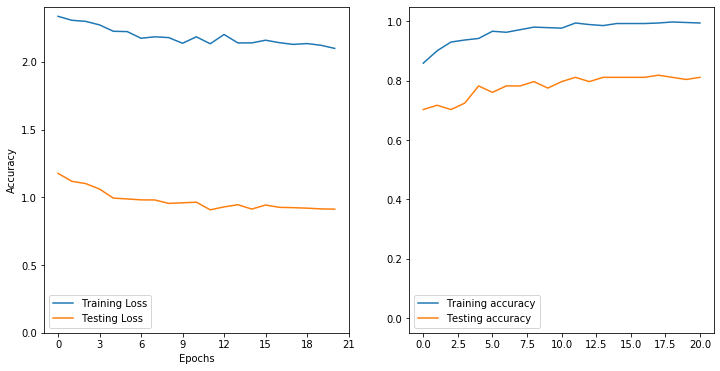

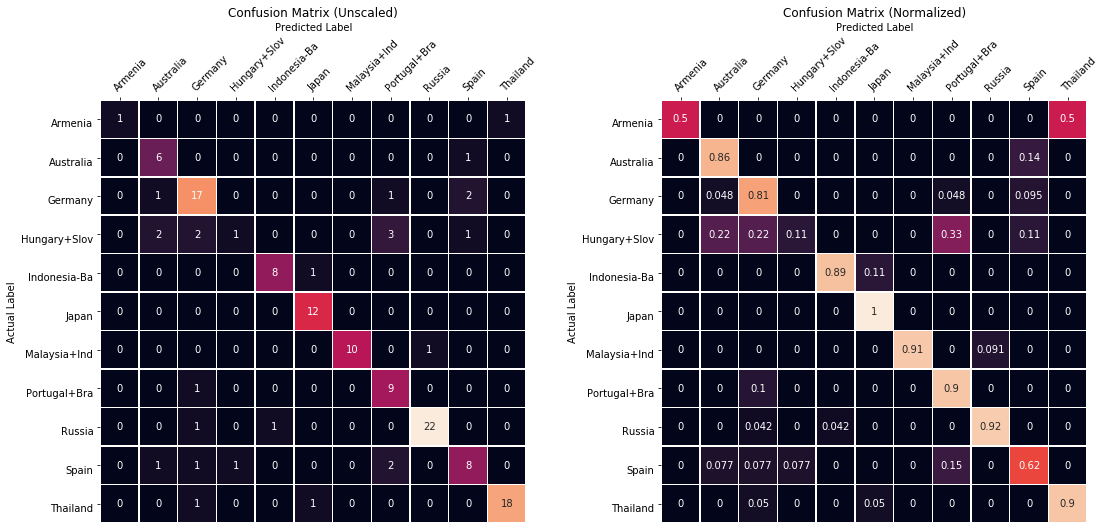

In [10]:
models, y_true, y_pred, hists = train_utils.train_eval_kfold_crossval(
    generate_multi_out_xception_model,
    epochs=40,
    finetune_epochs=20,
    model_prefix='xcept_plus3_fc1_Nadam_finetune')

train_utils.display_training_hist(hists[-1])
train_utils.display_heatmaps(y_true, y_pred)
train_utils.print_classification_report(y_true, y_pred)

# Kept exhausting resources trying to run all 5 folds at once.
# Uncomment below to run one-by-one, usually with kernel restart in between
'''
model, fold_true, fold_pred, hist = train_utils.train_one_fold(
    generate_multi_out_xception_model,
    kfold_index=4,
    epochs=40,
    model_prefix='minloss_inner3_fc1_60_Nadam_finetune')
train_utils.display_training_hist(hist)
train_utils.display_heatmaps(fold_true, fold_pred)
train_utils.print_classification_report(fold_true, fold_pred)
'''

Creating feature extractor base model, trainable=False
Creating feature extractor base model, trainable=False
Creating feature extractor base model, trainable=False
Creating feature extractor base model, trainable=False
Creating feature extractor base model, trainable=False
                          precision    recall  f1-score   support

                 Armenia       1.00      0.55      0.71        11
               Australia       0.75      0.60      0.67        35
                 Germany       0.74      0.81      0.78       107
Hungary+Slovakia+Croatia       0.64      0.47      0.54        49
          Indonesia-Bali       0.80      0.91      0.85        45
                   Japan       0.97      0.94      0.95        62
      Malaysia+Indonesia       0.84      0.93      0.88        55
         Portugal+Brazil       0.67      0.81      0.73        54
                  Russia       0.88      0.90      0.89       124
                   Spain       0.65      0.66      0.66        6

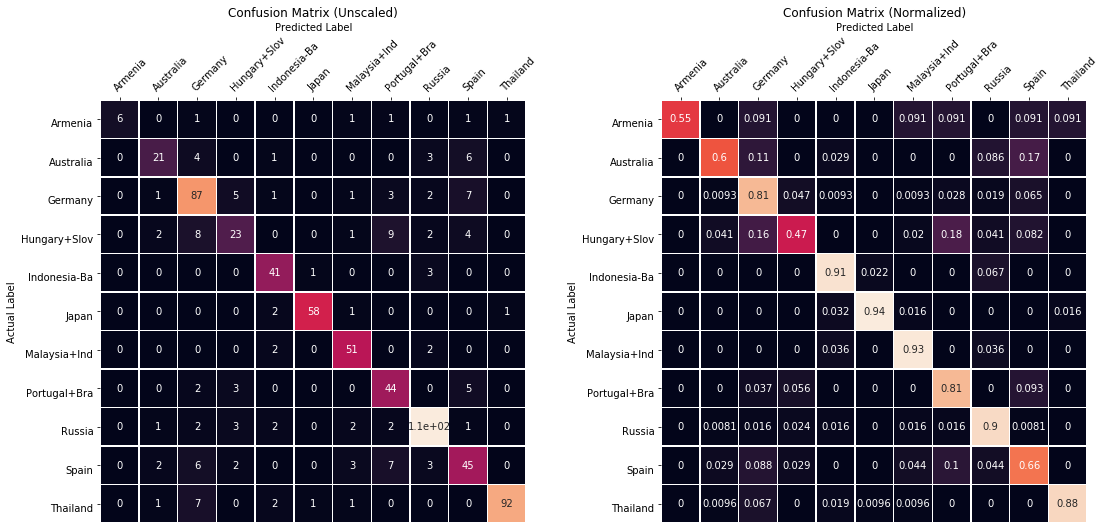

In [10]:
# Aggregate & display metrics for all best-networks written during training of all five folds
# This is performed automatically during k-fold training if it succeeds.  Need to run this
# manually you end up running the fold training individually/manually.
true_labels = []
pred_labels = []
for k in range(5):
    best_weights_file = f'minloss_inner3_fc1_60_Nadam_finetune_finetuned_{k}.hdf5'
    model = generate_multi_out_xception_model()
    model.load_weights(best_weights_file)
    
    test_ds = train_utils.create_test_dataset(k, INPUT_IMG_SIZE_3, xcept_preproc)
    for batch in test_ds:
        img_batch, label_batch = batch 
        calc_labels = model(img_batch).numpy()
        true_labels.append(np.argmax(label_batch, axis=1))
        pred_labels.append(np.argmax(calc_labels, axis=1))

cat_true_labels = np.concatenate(true_labels, axis=0)
cat_pred_labels = np.concatenate(pred_labels, axis=0)
train_utils.display_heatmaps(cat_true_labels, cat_pred_labels)
train_utils.print_classification_report(cat_true_labels, cat_pred_labels)

# (SKIPPED) Triplet Sampling
Manually train batches of triplets, attempting to reduce Euclidean distance between samples within the same country, and increase dist between samples from different countries.

**NOTE:** This section is a stub.  We got satisfactory results without this method and time was limited.  However, I believe that this is worth trying if the current best models aren't good enough.

In [ ]:
def generate_triplet_loss_model():
    fex_base = FEX_BASE_CREATE()
    inp_layer = fex_base.layers[0].input
    inter_layers = [fex_base.layers[l].output for l in INTERMEDIATE_LAYERS]
    out_layer = fex_base.layers[-1].output
    
    # GlobalAvgPooling of all 3 intermediate layers and the normal Xception output layer
    x = multiple_inters = [L.GlobalAveragePooling2D()(lout) for lout in (inter_layers + [out_layer])]
    
    # Concatenate those four layers together into a 4,232-feature vector
    x = combined = L.Concatenate(axis=-1)(multiple_inters)
    
    # 64-dense layer that will act as the embedding for the triplet loss...
    x = L.Dense(64)(x)
    
    
# This computes the loss and applies the resulting gradients for one triplet
# This should be expanded for arbitrary batches of size 3N
def compute_apply_loss(model, optimizer, f_anchor, f_pos, f_neg, margin):
    model_input = tf.stack([f_anchor, f_pos, f_neg])
    with tf.GradientTape() as tape:
        model_output = model(model_input)
        embed_anchor, embed_pos, embed_neg = tf.split(model_output, num_or_size_splits=3, axis=0)
        loss = tf.max(0, tf.square(embed_anchor - embed_pos) - tf.square(embed_anchor - embed_neg) + margin)
        
    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

# ...    


## Save & Upload the Final Model

In [10]:
print(FINAL_MODEL_WEIGHTS_FILENAME)

church_temple_classify_weights.hdf5


In [14]:
import pickle
local_trained_fn = 'final_model_fine_tuned_fold0.hdf5'
    
try:
    import boto3
    
    s3_client = boto3.client('s3')
    print(f'Uploading model to S3: {FINAL_MODEL_WEIGHTS_FILENAME}')
    s3_client.upload_file(
        local_trained_fn,
        'acr-toptal-codingproj',
        FINAL_MODEL_WEIGHTS_FILENAME,
        ExtraArgs={'ACL': 'public-read'})
    print(f'Success!')
except Exception as e:
    print(f'Error uploading to S3, skipping: {str(e)}')

Uploading model to S3: church_temple_classify_weights.hdf5
Success!
